<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/regression_strategy_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression: various strategies and their outcomes

1. Standard
* Partial
* Naive sequential
* Decorrelated sequential
* Residual sequential
* Transfer learning






## Truth 

* General model: $y = f(x_1, x_2, \beta)$. 

* Linear model: $y = X_1 \beta_1 + X_2 \beta_2 + \epsilon$, where $X_1$ and $X_2$ are an $n \times p_1$ and an $n \times p_2$ matrix, respectively.




## Standard

Regress $y$ on $X_1$ and $X_2$ *simultaneously* : $\hat{y} = X_1 \hat{\beta}_1 + X_2 \hat{\beta}_2$




## Partial

Regress $y$ on $X_1$ only: $\hat{y} = X_1 \hat{\beta}_1$

* $X_2$ are omitted and hence become potential **confounders**.



## Naive sequential

1. Regress $y$ on $X_1$: $\hat{y}_1 = X_1 \hat{\beta}_1$
2. Regress $y$ on $X_2$: $\hat{y}_2 = X_2 \hat{\beta}_2$
3. $\hat{y} = \hat{y}_1 + \hat{y}_2 = X_1 \hat{\beta}_1 +  X_2 \hat{\beta}_2$



## Decorrelated sequential

Aka "sequential regression with decorrelation".

1. Regress $y$ on $X_1$: $\hat{y}_1 = X_1 \hat{\beta}_1$
2. Decorrelate $X_2$ from $X_1$: $\tilde{X}_2 = (I-P)X_2$
3. Regress $y$ on $\tilde{X}_2$: $\hat{y}_2 = \tilde{X}_2 \hat{\beta}_2$
4. $\hat{y} = \hat{y}_1 + \hat{y}_2 = X_1 \hat{\beta}_1 +  \tilde{X}_2 \hat{\beta}_2$



## Residual sequential

Aka "sequential regression using residuals".

1. Regress $y$ on $X_1$: $\hat{y}_1 = X_1 \hat{\beta}_1$
2. Get residual $r = y - \hat{y}_1 $
3. Regress $r$ on $X_2$: $\hat{r} = X_2 \hat{\beta}_2$
4. $\hat{y} = \hat{y}_1 + \hat{r} = X_1 \hat{\beta}_1 +  X_2 \hat{\beta}_2$


## Transfer learning

Suppose we have three datasets: 

| Dataset  	|  Size 	|     $X_1$    	|     $X_2$    	| $y$          	|
|:--------:	|:-----:	|:------------:	|:------------:	|--------------	|
|     1    	| Large 	| $\checkmark$ 	|              	| $\checkmark$ 	|
|     2    	| Large 	|              	| $\checkmark$ 	| $\checkmark$ 	|
|     3    	| Small 	| $\checkmark$ 	| $\checkmark$ 	| $\checkmark$ 	|

Notation: 
* $X^i_j$ ($i=1,2,3$ and $j=1,2$): $X_j$ matrix of the $i$-th dataset
* $y^i (i=1,2,3)$: $y$ of the $i$-th dataset


1. Regress $y^1$ on $X^1_1$: $\hat{y}^1 = X^1_1 \hat{\beta}_1 \Big( \text{or generally } \hat{y}^1_1 = f_1(X^1_1, \hat{\beta}_1) \Big)$
2. Regress $y^2$ on $X^2_2$: $\hat{y}^2 = X^2_2 \hat{\beta}_2 \Big( \text{or generally } \hat{y}^2_2 = f_2(X^2_2, \hat{\beta}_2) \Big)$
3. Compute $\hat{y}^3_1 = f_1(X^3_1, \hat{\beta}_1)$ and $\hat{y}^3_2 = f_2(X^3_2, \hat{\beta}_2)$
4. Regress $y^3$ on $\hat{y}^3_1$ and $\hat{y}^3_2$: $\hat{y}^3= \hat{\gamma}_1 \hat{y}^3_1 + \hat{\gamma}_2 \hat{y}^3_2 \Big( \text{or generally } \hat{y}^3 = f(\hat{y}^3_1, \hat{y}^3_2, \hat{\gamma}) = f\big(f_1(X^3_1, \hat{\beta}_1), f_2(X^3_2, \hat{\beta}_2), \hat{\gamma}\big)  \Big)$

## TL;DR

For **linear regression** models:

|         Strategy        |   $\beta_1$  |   $\beta_2$  |      $y$     |
|:-----------------------:|:------------:|:------------:|:------------:|
|         Standard        | $\checkmark$ | $\checkmark$ | $\checkmark$ |
|         Partial         |   $\times$   |              |              |
|     Naive sequential    |   $\times$   |   $\times$   |              |
| Decorrelated sequential |   $\times$   | $\checkmark$ | $\checkmark$ |
|   Residual sequential   |   $\times$   |              |              |
|    Transfer learning    |   $\times$   |   $\times$   |              |

Notations:
* $\beta_1$:
* $\beta_2$:
* $y$:
* $\checkmark$:
* $\times$: 

In [0]:
from __future__ import division, print_function
import itertools
from functools import reduce

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [0]:
def get_X_y(n=1000, p=2, r=0, sigma=0.1, b=None, seed=0):
    """Generate X from multivariable standard normal distribution,
    and y according to a linear model. 
    
    :param n: sample size
    :param p: total number of features
    :param r: correlation coefficients between features
    :param sigma: noise
    :param b: beta vector
    :param seed: seed for random number generation
    """
    mu = [0] * p
    cov = np.identity(p)*(1-r) + np.ones((p,p))*r

    np.random.seed(seed)
    X = np.random.multivariate_normal(mu, cov, size=n)
    
    if b is None:
        b = list(range(1, p+1))
    y = np.dot(X, b) + np.random.randn(n)*sigma
    
    return X, y

In [0]:
def plot(y, yhat, alpha=0.01):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(y, yhat, alpha=alpha)
    ymin = min(list(y) + list(yhat))
    ymax = max(list(y) + list(yhat))
    ax.plot([ymin, ymax], [ymin, ymax], '-r')
    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$\hat{y}$', rotation=0)
    plt.show()

# Standard

In [46]:
X, y = get_X_y(r=0, b=[1,2], n=10000, seed=0)
f = LinearRegression(fit_intercept=False).fit(X, y)
f.coef_

array([1.00066028, 2.00168218])

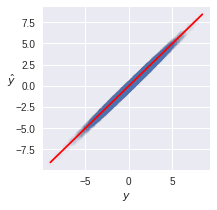

In [51]:
plot(y, f.predict(X))

In [55]:
X, y = get_X_y(r=0.5, b=[1,2], n=10000, seed=0)
f = LinearRegression(fit_intercept=False).fit(X, y)
f.coef_

array([0.99793661, 2.00130096])

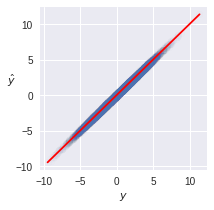

In [56]:
plot(y, f.predict(X))

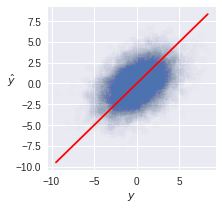

4.9519693378765

In [159]:
plot(y, 2*x)
mean_squared_error(y, 2*x)

# Partial

In [4]:
X, y = get_X_y(r=0, b=[1,3], n=10000, seed=0)
X1 = X[:,[0]]
f = LinearRegression(fit_intercept=False).fit(X1, y)
f.coef_

array([1.01535165])

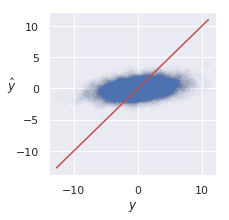

In [6]:
plot(y, f.predict(X1))

In [169]:
X, y = get_X_y(r=0.9, b=[1,2], n=10000, seed=0)
X1 = X[:,[0]]
f = LinearRegression(fit_intercept=False).fit(X1, y)
f.coef_

array([2.79860622])

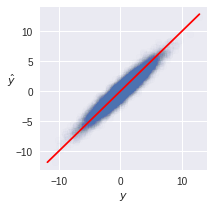

In [170]:
plot(y, f.predict(X1))

### Side note

Sometimes it's better when the cloud is more horizontal: when $y$ and $\hat{y}$ are gaussian distributed and hence most of the points are close to the origin. Even though the cloud looks better when scaling $\hat{y}$ to make it trend better with $y$, mse is larger because of the higher cost by scaling the points near the center. 

8.651552308067114

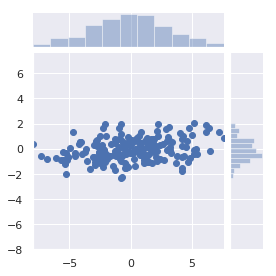

In [32]:
X, y = get_X_y(r=0, b=[1,3], n=200, seed=0)
X1 = X[:,[0]]
f = LinearRegression(fit_intercept=False).fit(X1, y)
yhat = f.predict(X1)

lim = [min(list(y)+list(yhat)), max(list(y)+list(yhat))]
sns.jointplot(y, yhat, height=4, xlim=lim, ylim=lim)

mean_squared_error(y, yhat)

11.694310110137799

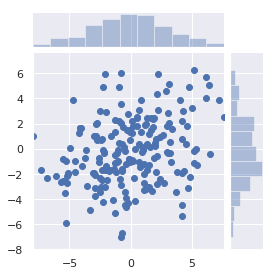

In [33]:
yhat2 = f.predict(X1) * 3

lim = [min(list(y)+list(yhat2)), max(list(y)+list(yhat2))]
sns.jointplot(y, yhat2, height=4, xlim=lim, ylim=lim)

mean_squared_error(y, yhat2)

# Naive and decorrelated sequential



Given an $n$-by-$p$ matrix $X$  ($n>p$), a **projection matrix** that projects any $y \in \mathbb{R}^n$ onto the subspace spanned by (the column vectors of) $X$ is:

$P = X(X^T X)^{-1} X^T$ (aka the "*hat matrix*" in linear regression literature). 

It's easy to verify: 
* $PX = X(X^T X)^{-1} X^T X = X$
* $PP = X(X^T X)^{-1} X^T X(X^T X)^{-1} X^T = X(X^T X)^{-1} X^T = P$

Both are consistent with that $P$ represents a projection operator onto the $X$ subspace.

The projection operator to the *orthogonal complement* of $X$ can be represented by $I - P$: 

* $\langle P y, (I-P) y \rangle = y^T P^T (I - P) y = y^T P^T y - y^T P^T P y = y^T P^T y - y^T P P y = 0$ (it makes use of $P^T = (X(X^T X)^{-1} X^T)^T = X (X^T X)^{-1} X^T = P$ and that the inverse of a symmetric matrix is [also symmetric](https://math.stackexchange.com/a/3162436/224349)).

---

Computing $X(X^T X)^{-1} X^T$: 

Singular value decomposition: $X = U \Sigma V^T$ 

$X(X^T X)^{-1} X^T = U \Sigma V^T (V \Sigma U^T U \Sigma V^T)^{-1} V \Sigma U^T = U \Sigma V^T (V \Sigma^2 V^T)^{-1} V \Sigma U^T = U \Sigma V^T V \Sigma^{-2} V^T V \Sigma U^T = U U^T$

In [0]:
def decorrelate(X, k):
    """Return the last p-k columns of X (that is, X[:,k:]) decorrelated 
    from the first k columns (that is, X[:,:k]). 
    
    :param X:
    :param k: 
    :return:
    """
    assert k < X.shape[1]
    X1, X2 = X[:,:k], X[:,k:]
    U, S, Vt = np.linalg.svd(X1, full_matrices=False)
    X2_ = X2 - np.dot(np.dot(U, U.T), X2)
    return X1, X2, X2_

In [100]:
X, y = get_X_y(r=0, b=[1,2], n=10000, seed=0)
X1, X2, X2_ = decorrelate(X, k=1)

f1 = LinearRegression(fit_intercept=False).fit(X1, y)
f2 = LinearRegression(fit_intercept=False).fit(X2, y)
f2_ = LinearRegression(fit_intercept=False).fit(X2_, y)

f1.coef_, f2.coef_, f2_.coef_

(array([1.01045728]), array([2.0066708]), array([2.00168218]))

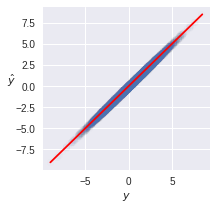

In [101]:
plot(y, f1.predict(X1)+f2.predict(X2))

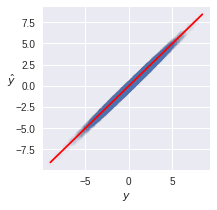

In [102]:
plot(y, f1.predict(X1)+f2_.predict(X2_))

In [103]:
X, y = get_X_y(r=0.5, b=[1,2], n=10000, seed=0)
X1, X2, X2_ = decorrelate(X, k=1)

f1 = LinearRegression(fit_intercept=False).fit(X1, y)
f2 = LinearRegression(fit_intercept=False).fit(X2, y)
f2_ = LinearRegression(fit_intercept=False).fit(X2_, y)

f1.coef_, f2.coef_, f2_.coef_

(array([2.00804018]), array([2.50929077]), array([2.00130096]))

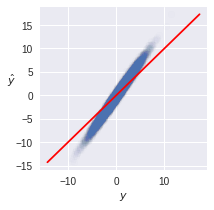

In [104]:
plot(y, f1.predict(X1)+f2.predict(X2))

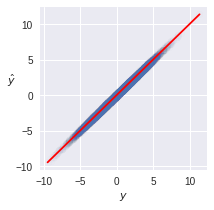

In [105]:
plot(y, f1.predict(X1)+f2_.predict(X2_))

# Residual sequential

 



In [112]:
X, y = get_X_y(r=0, b=[1,2], n=10000, seed=0)
X1, X2 = X[:,:1], X[:,1:]

f1 = LinearRegression(fit_intercept=False).fit(X1, y)
res = y - f1.predict(X1)

f2 = LinearRegression(fit_intercept=False).fit(X2, res)

f1.coef_, f2.coef_

(array([1.01045728]), array([2.00163334]))

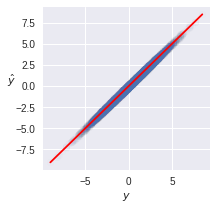

In [113]:
plot(y, f1.predict(X1)+f2.predict(X2))

In [42]:
X, y = get_X_y(r=0.5, b=[1,3], n=10000, seed=0)
X1, X2 = X[:,:1], X[:,1:]

f1 = LinearRegression(fit_intercept=False).fit(X1, y)
res = y - f1.predict(X1)

f2 = LinearRegression(fit_intercept=False).fit(X2, res)

f1.coef_, f2.coef_

(array([2.51276366]), array([2.23019316]))

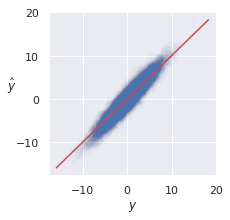

In [43]:
plot(y, f1.predict(X1)+f2.predict(X2))

# Transfer learning



In [0]:
def get_dat(n1, n2, n3, n4, sigma, r, seed=0):
    n = n1 + n2 + n3 + n4
    X, y = get_X_y(n=n, p=4, r=r, sigma=sigma, b=[1,1,1,1], seed=seed)

    X1, y1 = X[:n1], y[:n1]
    X2, y2 = X[n1:n1+n2], y[n1:n1+n2]
    X3, y3 = X[n1+n2:n1+n2+n3], y[n1+n2:n1+n2+n3]
    X4, y4 = X[n1+n2+n3:n], y[n1+n2+n3:n]
    
    return X1, y1, X2, y2, X3, y3, X4, y4

In [0]:
def get_mses(dat):
    X1, y1, X2, y2, X3, y3, X4, y4 = dat
    f1 = LinearRegression(fit_intercept=False).fit(X1[:,:2], y1)
    f2 = LinearRegression(fit_intercept=False).fit(X2[:,2:], y2)

    X3_ = np.stack((f1.predict(X3[:,:2]), f2.predict(X3[:,2:])), axis=1)

    f3_ = LinearRegression(fit_intercept=False).fit(X3_, y3)
    f3 = LinearRegression(fit_intercept=False).fit(X3, y3)
    
    mse1_train = mean_squared_error(y3, f3.predict(X3))
    mse2_train = mean_squared_error(y3, f3_.predict(X3_))
    
    X4_ = np.stack((f1.predict(X4[:,:2]), f2.predict(X4[:,2:])), axis=1)
    
    mse1_test = mean_squared_error(y4, f3.predict(X4))
    mse2_test = mean_squared_error(y4, f3_.predict(X4_))
    
    return mse1_train, mse2_train, mse1_test, mse2_test

In [0]:
n12s = [100, 10000]
sigmas = [0.1, 10]
rs = [0, 0.9]

sdfs = []

for i in range(100):
    out = []
    for n12, sigma, r in itertools.product(n12s, sigmas, rs):
        dat = get_dat(n12, n12, 100, 10000, sigma, r, seed=3)
        out.append([n12, sigma, r]+list(get_mses(dat)))

    df = pd.DataFrame(out, columns=['n12', 'sigma', 'r', 'train1', 'train2', 'test1', 'test2'])
    
    df['rtrain'] = df.train2 / df.train1
    df['rtest'] = df.test2 / df.test1
    
    sdf = df.iloc[:,[0,1,2,-2,-1]]
    
    sdfs.append(sdf)

In [194]:
reduce(lambda x, y: x+y, sdfs) / 100

,n12,sigma,r,rtrain,rtest
0,100,0.1,0.0,4.775885,3.794811
1,100,0.1,0.9,1.254949,1.341576
2,100,10.0,0.0,1.014872,0.983328
3,100,10.0,0.9,1.025793,0.999802
4,10000,0.1,0.0,1.224154,1.183330
5,10000,0.1,0.9,1.059577,0.937621
6,10000,10.0,0.0,1.012161,1.000879
7,10000,10.0,0.9,1.086600,0.935494
